In [1]:
import retro
import gym

from matplotlib import pyplot as plt
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecFrameStack
import os
from stable_baselines3 import PPO

from stable_baselines3.common.results_plotter import load_results, ts2xy
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

import cv2


CHECK_FREQ_NUMB = 10000
TOTAL_TIMESTEP_NUMB = 2000000
LEARNING_RATE = 0.00005
N_STEPS = 512
GAMMA = 0.9
BATCH_SIZE = 64
N_EPOCHS = 10
DOWN_SAMPLE_RATE = 3
SKIP_NUMB = 2
EPISODE_NUMBERS = 20

# 跳过画面每2真保留一个画面，节省计算时间
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if done:
                break
        return obs, reward, done, info

class Discretizer(gym.ActionWrapper):
    """
    Wrap a gym environment and make it use discrete actions.
    Args:
        combos: ordered list of lists of valid button combinations
    """

    def __init__(self, env, combos):
        super().__init__(env)
        assert isinstance(env.action_space, gym.spaces.MultiBinary)
        buttons = env.unwrapped.buttons
        self._decode_discrete_action = []
        for combo in combos:
            arr = np.array([False] * env.action_space.n)
            for button in combo:
                arr[buttons.index(button)] = True
            self._decode_discrete_action.append(arr)

        self.action_space = gym.spaces.Discrete(
            len(self._decode_discrete_action))

    def action(self, act):
        return self._decode_discrete_action[act].copy()


class SonicDiscretizer(Discretizer):
    """
    Use Sonic-specific discrete actions
    based on https://github.com/openai/retro-baselines/blob/master/agents/sonic_util.py
    """
    # B是子弹

    def __init__(self, env):
        super().__init__(env=env, combos=[['RIGHT', 'B'],['RIGHT'],['RIGHT', 'A', 'B'], ['B'],['LEFT', 'A', 'B'],['RIGHT', 'UP', 'B']])



/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os


In [3]:

SCRIPT_DIR = os.path.dirname(os.path.abspath("./Contra-Nes"))
os.path.join(SCRIPT_DIR, "Contra-Nes")

'/workspace/Contra_train/Contra-Nes'

In [4]:
retro.data.Integrations.add_custom_path(
        os.path.join(SCRIPT_DIR, "Contra-Nes")
)

print("Contra-Nes" in retro.data.list_games(inttype=retro.data.Integrations.ALL))

rom_path=os.path.join(SCRIPT_DIR, "Contra-Nes/")

env = retro.make(game=rom_path,state="Level2",inttype=retro.data.Integrations.CUSTOM_ONLY)
# 
env = SonicDiscretizer(env)
# 跳过一阵的画面
env = SkipFrame(env, skip=SKIP_NUMB)
env = GrayScaleObservation(env, keep_dim=True)

True


In [5]:
env.reset()


Type:        dict
String form: {'xscroll': 0, 'Animation': 2, 'Weapon': 0, 'player_state': 1, 'die': 1, 'ypos': 168, 'level': 1, 'xpos': 114, 'lives': 2, 'score': 0, 'beat_boss': 4}
Length:      11
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)

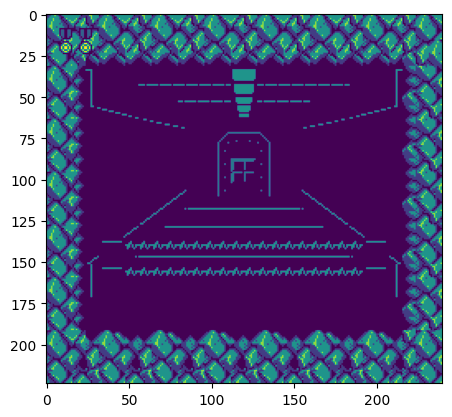

In [15]:
state, reward, done, info = env.step(1)
plt.imshow(state)
